# Parallelizing analysis

As we approach the exascale barrier, researchers are handling increasingly large volumes of molecular dynamics (MD) data. Whilst MDAnalysis is a flexible and relatively fast framework for complex analysis tasks in MD simulations, implementing a parallel computing framework would play a pivotal role in accelerating the time to solution for such large datasets.	

This document illustrates how you can run your own analysis scripts in parallel with MDAnalysis.

**Last executed:** Sep 23, 2020 with MDAnalysis 2.0.0-dev0

**Last updated:** August 2020

**Minimum version of MDAnalysis:** 2.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisData
* dask (<a href="https://dask.org/">https://dask.org/</a>)
* dask.distributed (<a href="https://distributed.dask.org/en/latest/">https://distributed.dask.org/en/latest/</a>)  
* joblib (<a href="https://joblib.readthedocs.io/en/latest/">https://joblib.readthedocs.io/en/latest/</a>)

In [1]:
import MDAnalysis as mda
from MDAnalysisData.adk_equilibrium import fetch_adk_equilibrium

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Background

In MDAnalysis, most implemented analysis methods are based on `AnalysisBase`, which provides a generic API for users to <a href=https://mdanalysis.org/UserGuide/examples/analysis/custom_trajectory_analysis.html>write their own trajectory analysis</a>. However, this framework only takes single-core power of the PC by iterating through the trajectory and running a frame-wise analysis. Below we aim to first explore some possible simple implementations of parallelism, including using multiprocessing and dask. We will also discuss the acceleration approaches that should be considered, ranging from your own multiple-core laptops/desktops to distributed clusters.

### Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosopho-transferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>). The trajectory has 4187 frames, which will take quite some time to run the analysis on with the conventional serial (single-core) approach.

Note: downloading these datasets from MDAnalysisData may take some time.

In [2]:
adk = fetch_adk_equilibrium()
u = mda.Universe(adk.topology, adk.trajectory)
protein = u.select_atoms('protein')
print(len(u.trajectory))

4187


### Radius of gyration
For a detail description of this analysis, read [Writing your own trajectory](https://mdanalysis.org/UserGuide/examples/analysis/custom_trajectory_analysis.html).

Here is a common form of single-frame method that we can normally see inside `AnalysisBase`. It may contain both some dynamic parts that changes along time either implicitly or explicitly (e.g. `AtomGroup`) and some static parts (e.g. a reference frame).

In [3]:
def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()
    
    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y
    
    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])
    
    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

### Serial Analysis

Below is the serial version of the analysis that we normally use.

In [4]:
result = []
for frame in u.trajectory:
    result.append(radgyr(atomgroup=protein,
                         masses=protein.masses,
                         total_mass=np.sum(protein.masses)))

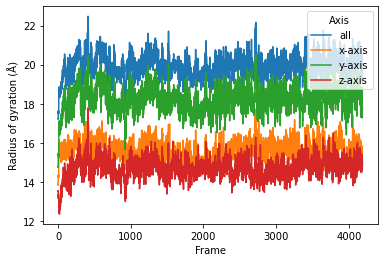

In [5]:
result = np.asarray(result)

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
serial = pd.DataFrame(result, columns=labels)
serial["Frame"] = serial.index
serial = serial.melt(id_vars="Frame", var_name="Axis",
                     value_name="Radius of gyration (Å)")
sns.lineplot(data=serial, x="Frame", y="Radius of gyration (Å)",
             hue="Axis")

## Parallelization in a simple per-frame fashion

### Frame-wise form of the function

The coordinates of the ``atomgroup`` analysed change with each frame of the trajectory. We need to explicitly point the analysis function to the frame that needs to be analysed with a ``frame_index``: `atomgroup.universe.trajectory[frame_index]` in order to update the positions (and any other dynamic per-frame information) appropriately. Therefore, the first step to making the ``radgyr`` function parallelisable is to add a ``frame_index`` argument.

In [6]:
def radgyr_per_frame(frame_index, atomgroup, masses, total_mass=None):
    
    # index the trajectory to set it to the frame_index frame
    atomgroup.universe.trajectory[frame_index]
    
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()
    
    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y
    
    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])
    
    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

### Parallelization with dask

[Dask](https://docs.dask.org/en/latest/) is a flexible library for parallel computing in Python. It provides advanced parallelism for analytics and has been integrated or utilized in many scientific softwares. It can be scaled from one single computer to a cluster of computers inside a HPC center.

Dask has a dynamic task scheduling system with synchronous (single-threaded), threaded, multiprocessing and distributed schedulers. The wrapping function in dask, `dask.delayed`, mimics for loops and wraps Python code into a Dask graph. This code can then be easily run in parallel, and visualized with `dask.visualize()` to examine if the task is well distributed. The code inside `dask.delayed` is not run immediately on execution, but pushed into a job queue waiting for submission. You can read more on [dask website](https://docs.dask.org/en/latest/delayed.html).


Comaring to `multiprocssing`, the downside of `multiprocessing` is that it is mostly focused on single-machine multicore parallelism (without extra manager). It is hard to operate on multimachine conditions. Below are two simple examples to use Dask to achieve the same task as `multiprocessing` does.

The API of `dask` is similar to `multiprocessing`. It also creates a pool of workers for your single machine with the given resources.

Note: The threaded scheduler in Dask (similar to `threading` in Python) should not be used as it will mess up with the state (timestep) of the trajectory.

In [7]:
import dask
import dask.multiprocessing
dask.config.set(scheduler='processes')

Below is how you can utilize `dask.distributed` module to build a local cluster.

Note: this is not really needed for your laptop/desktop. Using dask.distributed may even slow down the performance, but it provides a diagnostic dashboard that can provide valuable insight on performance and progress.

See limitations here: https://distributed.dask.org/en/latest/limitations.html

In [8]:
from dask.distributed import Client

client = Client()
client

<Client: 'tcp://127.0.0.1:50019' processes=4 threads=8, memory=16.00 GiB>

First we have to create a list of jobs and transform them with `dask.delayed()` so they can be processed by Dask.

In [9]:
job_list = []
for frame_index in range(u.trajectory.n_frames):
    job_list.append(dask.delayed(radgyr_per_frame(frame_index,
                                        atomgroup=protein,
                                        masses=protein.masses,
                                        total_mass=np.sum(protein.masses))))

Then we simply use `dask.compute()` to get a list of ordered results.

In [10]:
result = dask.compute(job_list)

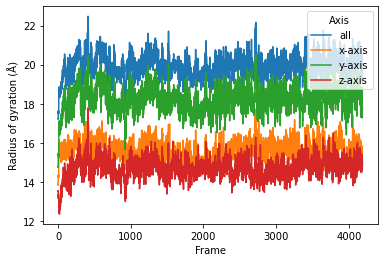

In [11]:
daskproc = pd.DataFrame(result[0], columns=labels)
daskproc["Frame"] = daskproc.index
daskproc = daskproc.melt(id_vars="Frame", var_name="Axis",
                         value_name="Radius of gyration (Å)")
sns.lineplot(data=daskproc, x="Frame", y="Radius of gyration (Å)",
             hue="Axis")

We can also use the old `radgyr` function because `dask` is more flexible on the input arguments.

Note: the associated timestamp of `protein` will change during the trajectory iteration, so the processes are always aware which timestep the trajectory is in and change the `protein` (e.g. its coordinates) accordingly.

In [12]:
job_list = []
for frame in u.trajectory:
    job_list.append(dask.delayed(radgyr(atomgroup=protein,
                                        masses=protein.masses,
                                        total_mass=np.sum(protein.masses))))

Then we again use `dask.compute()` to get a list of ordered results.

In [13]:
result = dask.compute(job_list)

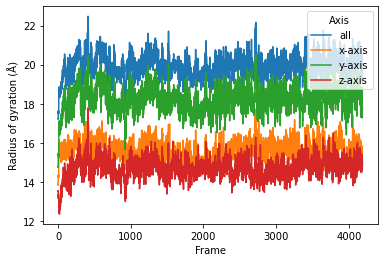

In [14]:
daskproc2 = pd.DataFrame(result[0], columns=labels)
daskproc2["Frame"] = daskproc2.index
daskproc2 = daskproc2.melt(id_vars="Frame", var_name="Axis",
                           value_name="Radius of gyration (Å)")
sns.lineplot(data=daskproc2, x="Frame", y="Radius of gyration (Å)",
             hue="Axis")

We can also use Dask dashboard (with dask.distributed.Client) to examine how jobs are distributed along all the workers. Each green bar below represents one job, i.e. running `radgyr` on one frame of the trajectory

<center>
<div style="width: 650px; text-align: center;">
    
![Dask task stream](../images/parallel_analysis/per_frame_dask.png)

</div>
</center>

## See Also

The parallel version of MDAnalysis is still under development. For existing solutions and some implementations of parallel analysis, go to [PMDA](https://www.mdanalysis.org/pmda/). PMDA (<a data-cite="fan_pmda_2019" href="https://doi.org/10.25080/Majora-7ddc1dd1-013">Shujie *et al.*, 2019</a>) applies the aforementioned split-apply-combine scheme with Dask. In the future, it may provide a framework that consolidates all the parallelisation schemes described in this tutorial.

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[4] Max&nbsp;Linke Shujie&nbsp;Fan, Ioannis Paraskevakos, Richard&nbsp;J. Gowers, Michael Gecht, and Oliver Beckstein.
<span class="bibtex-protected">PMDA</span> - <span class="bibtex-protected">P</span>arallel <span class="bibtex-protected">M</span>olecular <span class="bibtex-protected">D</span>ynamics <span class="bibtex-protected">A</span>nalysis.
In <span class="bibtex-protected">C</span>hris <span class="bibtex-protected">C</span>alloway, <span class="bibtex-protected">D</span>avid <span class="bibtex-protected">L</span>ippa, <span class="bibtex-protected">D</span>illon <span class="bibtex-protected">N</span>iederhut, and <span class="bibtex-protected">D</span>avid <span class="bibtex-protected">S</span>hupe, editors, <em><span class="bibtex-protected">P</span>roceedings of the 18th <span class="bibtex-protected">P</span>ython in <span class="bibtex-protected">S</span>cience <span class="bibtex-protected">C</span>onference</em>, 134 &ndash; 142. 2019.
<a href="https://doi.org/10.25080/Majora-7ddc1dd1-013">doi:10.25080/Majora-7ddc1dd1-013</a>.